In [12]:
import numpy as np
from numpy import linalg as la
from numpy import *
from numpy import random as rrr
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from time import time
import joblib
from collections import namedtuple, deque
import math
import random as rnd
from scipy import stats
# importing movie py libraries
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

In [13]:
print (torch.__version__, torch.cuda.is_available())
print(torch.version.cuda)
print (torch.cuda.get_device_name())
#device= 'cpu'
device= 'cuda'

2.2.2 True
11.8
NVIDIA RTX 6000 Ada Generation


In [14]:
## Choose a system (this is just for name)
system = 'duffing' 
# system = 'double_well'

In [15]:
num_steps = 15000
k_grid = 32

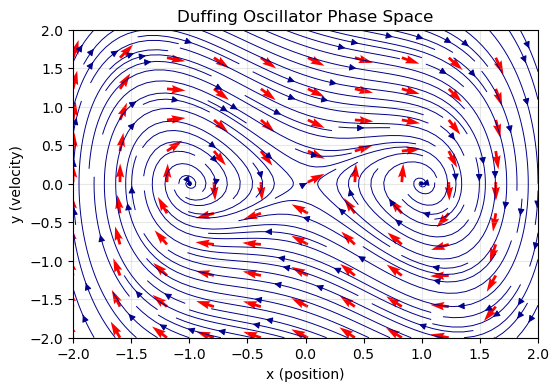

In [16]:
from duffing_system_2d import simulate_trajectory

"""
Main script for Duffing oscillator system simulation
"""

# Set parameters for the Duffing oscillator
delta = 0.5
alpha = -1
beta = 1
gamma = 0
omega = 0
sigma = 0.08

# Create a grid of points for phase space visualization
x_plot = np.linspace(-2, 2, 100)
y_plot = np.linspace(-2, 2, 100)
XX, YY = np.meshgrid(x_plot, y_plot)

# Calculate vector field for phase space plot
U = YY  # dx/dt = y
V = -delta*YY - alpha*XX - beta*(XX**3) + gamma*np.cos(omega*0)  # dy/dt at t=0

# Normalize the arrows
magnitude = np.sqrt(U**2 + V**2)
U_norm = U / magnitude
V_norm = V / magnitude

# Plot the phase space
plt.figure(figsize=(6, 4))
plt.streamplot(XX, YY, U, V, density=1.5, color='darkblue', linewidth=0.7)
plt.quiver(XX[::10, ::10], YY[::10, ::10], U_norm[::10, ::10], V_norm[::10, ::10], 
           color='red', scale=25)
plt.title('Duffing Oscillator Phase Space')
plt.xlabel('x (position)')
plt.ylabel('y (velocity)')
plt.grid(alpha=0.3)
plt.show()

def get_single_trajectory(x0, y0, T):
    """
    Produce SDE trajectory starting at (x0, y0) over T steps.
    This function delegates the simulation to duffing_system_2d.simulate_trajectory.
    
    Args:
        x0: Initial x-coordinate (position)
        y0: Initial y-coordinate (velocity)
        T: Total simulation time steps
        
    Returns:
        Tuple of (data_matrix_single, lag_time)
    """
    return simulate_trajectory(x0, y0, T, delta=delta, alpha=alpha, beta=beta, gamma=gamma, omega=omega)

In [17]:
# #define the domain of the dynamical system
# x_min= -3
# x_max= 3
# y_min = -4
# y_max= 4

# from double_well_potential_2d import potential, simulate_trajectory

# """
# Main script for plotting and trajectory generation.
# Imports potential and simulate_trajectory from double_well.py.
# """

# # Plot the potential landscape
# x_plot = np.linspace(-2, 2, 100)
# y_plot = np.linspace(-3, 3, 100)
# XX, YY = np.meshgrid(x_plot, y_plot)
# ZZ = potential(XX, YY)

# plt.figure(figsize=(6, 4))
# plt.contourf(XX, YY, ZZ, levels=20, cmap='coolwarm')
# plt.colorbar(label='Potential')
# plt.title('2D Double Well Potential Landscape')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.show()

# # Generate a single SDE trajectory

# def get_single_trajectory(x0, y0, T):
#     """
#     Produce SDE trajectory starting at (x0, y0) over T steps.
#     This function delegates the simulation to double_well.simulate_trajectory.
#     """
#     return simulate_trajectory(x0, y0, T)

In [18]:
reward_hist= joblib.load (f'dqn_history{k_grid}x{k_grid}_{num_steps}steps_example_{system}_final.jbl')
os.makedirs(f'figures_dqn_{system}', exist_ok=True)

In [19]:
def make_trajectory_from_state(state, chunk_len=100):  # Default is still 100
    state_len = state.shape[1]
    chunk_list = []
    T = 3*chunk_len  # Use the parameter
    
    for ii in arange(state_len):
        x0_single = state[0, ii]
        y0_single = state[1, ii]
        
        data_matrix_single, lag_time = get_single_trajectory(x0_single, y0_single, T)
        chunk_list.append(data_matrix_single)
    
    data_matrix_single = hstack(chunk_list)
    return data_matrix_single, lag_time

In [20]:
rewards_all=[]
states_all= []
actions_all= []
next_states_all= []
for ii in arange(len (reward_hist)):
        curr_list= reward_hist[ii]
        rewards_all.append (curr_list[-1])
        states_all.append (curr_list[0])
        actions_all.append (int (curr_list[1].squeeze()))
        next_states_all.append (curr_list[2])

In [21]:
def make_trajectory_from_state_list (state_list):
    n_traj= len (state_list)
    traj_list= []
    for kk in tqdm (arange (n_traj)):
        trajectory, lag_time= make_trajectory_from_state(state_list[kk])
        traj_list.append (trajectory)
        trajectory_final= np.hstack (traj_list)
    return trajectory_final, lag_time

In [22]:
from solver_sdmd_torch_gpu4 import KoopmanNNTorch, KoopmanSolverTorch

# Main loop to run the entire process multiple times
num_iterations = 10  # Number of times to run the full process

for iteration in range(num_iterations):
    print(f"\n{'='*50}\nStarting iteration {iteration+1}/{num_iterations}\n{'='*50}")
    
    # Create a separate directory for each iteration
    iteration_dir = f"figures_dqn_{system}/iteration_{iteration+1}"
    os.makedirs(iteration_dir, exist_ok=True)
    
    # 0. Prepare a list to accumulate all evaluation points across iterations
    X_eval_list = []
    # for step_view in [1000,2000]:
    for step_view in [500,1000,1500,2000]:
        # Calculate dynamic chunk length based on step_view - starts smaller, grows with step_view
        dynamic_chunk_len = max(10, 20 + step_view // 10)
        
        # Determine number of trajectories - very few at the beginning, more later
        if step_view < 100:
            n_traj = 2  # Just 2 trajectory for very small step_view
        elif step_view < 500:
            n_traj = 3  # 3 trajectories for medium-small step_view
        elif step_view < 1000:
            n_traj = 5  # 5 trajectories for medium step_view
        else:
            n_traj = 8 + step_view // 1000  # More trajectories for larger step_view
        
        print(f"Iteration {iteration+1}, Step view: {step_view}, Trajectories: {n_traj}, Chunk length: {dynamic_chunk_len}")
        
        # Define a local function that uses the dynamic chunk length
        def make_trajectory_with_dynamic_length(state_list):
            n_traj_local = len(state_list)
            traj_list = []
            for kk in tqdm(arange(n_traj_local)):
                # Pass the dynamic chunk length to the inner function
                trajectory, lag_time = make_trajectory_from_state(state_list[kk], chunk_len=dynamic_chunk_len)
                traj_list.append(trajectory)
            trajectory_final = np.hstack(traj_list)
            return trajectory_final, lag_time
        
        # Build the small trajectory to train the solver using the dynamic length
        trajectory_final, lag_time = make_trajectory_with_dynamic_length(
            states_all[step_view:step_view + n_traj]
        )
        
        data_matrix_single = trajectory_final

        # 3. Prepare X and Y for training/validation
        data_X = data_matrix_single[:, :-1, :]
        data_Y = data_matrix_single[:, 1:, :]
        X = data_X.reshape(-1, data_X.shape[2])
        Y = data_Y.reshape(-1, data_Y.shape[2])
        
        # 4. Split into 70% train / 30% valid
        len_all = X.shape[0]
        split_idx = int(0.7 * len_all)
        data_x_train = X[:split_idx]
        data_x_valid = X[split_idx + 1:]
        data_y_train = Y[:split_idx]
        data_y_valid = Y[split_idx + 1:]
        data_train = [data_x_train, data_y_train]
        data_valid = [data_x_valid, data_y_valid]

        # 5. Initialize solver with neural-network dictionary - add iteration to checkpoint
        checkpoint_file = f'example_{system}_dqn_iter_{iteration+1}_ckpt.torch'
        basis_function = KoopmanNNTorch(
            input_size=2,
            layer_sizes=[10],
            n_psi_train=10
        ).to(device)
        solver = KoopmanSolverTorch(
            dic=basis_function,
            target_dim=np.shape(data_x_train)[-1],
            reg=0.1,
            checkpoint_file=checkpoint_file,
            fnn_checkpoint_file=f'example_{system}_fnn_dqn_iter_{iteration+1}.torch',
            a_b_file=f'sde_coefficients_example_{system}_dqn_iter_{iteration+1}.jbl',
            generator_batch_size=2,
            fnn_batch_size=32,
            delta_t=lag_time
        )

        # 6. Train the solver
        solver.build_with_generator(
            data_train=data_train,
            data_valid=data_valid,
            epochs=6,
            batch_size=512,
            lr=1e-5,
            log_interval=10,
            lr_decay_factor=0.8
        )

        # 7. Extract eigenvalues (for logging or unit-circle plot)
        evalues = solver.eigenvalues.T
        print(f"Iteration {iteration+1}, Step {step_view} - Eigenvalues: {evalues[:10]}")

        # Plot eigenvalues on unit circle
        plt.figure(figsize=(6, 4))
        plt.scatter(evalues.real, evalues.imag, label='Eigenvalues')
        theta = np.linspace(0, 2*np.pi, 100)
        plt.plot(np.cos(theta), np.sin(theta), '--', label='Unit Circle')
        plt.title(f'Eigenvalues (iter={iteration+1}, step_view={step_view})')
        plt.xlabel('Real Part')
        plt.ylabel('Imaginary Part')
        plt.axis('equal')
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.legend()
        eigenvalue_filename = f'{iteration_dir}/eigenvalues_{system}_dqn_test_{iteration+1}_step_{step_view}.png'
        plt.savefig(eigenvalue_filename)
        plt.close()  # Close to free memory
        
        # Save top 10 eigenvalues sorted by real part (largest to smallest)
        # Convert complex eigenvalues to a numpy array if not already
        evalues_np = np.array(evalues) if not isinstance(evalues, np.ndarray) else evalues
        # Sort eigenvalues by real part in descending order
        sorted_indices = np.argsort(-evalues_np.real)  # Negative sign for descending order
        top10_evalues = evalues_np[sorted_indices[:10]]  # Take top 10
        
        # Create a text file to store the eigenvalues
        eigenvalues_txt_filename = f'{iteration_dir}/top10_eigenvalues_test_{iteration+1}_step_{step_view}.txt'
        with open(eigenvalues_txt_filename, 'w') as f:
            f.write(f"Top 10 Eigenvalues for Iteration {iteration+1}, Step {step_view}\n")
            f.write("Sorted by real part (largest to smallest)\n")
            f.write("-" * 50 + "\n")
            f.write(f"{'Index':<6} {'Real Part':<15} {'Imaginary Part':<15} {'Magnitude':<15} {'Phase':<15}\n")
            f.write("-" * 70 + "\n")
            
            for i, eig in enumerate(top10_evalues):
                # Calculate magnitude and phase (in degrees)
                magnitude = np.abs(eig)
                phase = np.angle(eig, deg=True)
                f.write(f"{i+1:<6} {eig.real:<15.6f} {eig.imag:<15.6f} {magnitude:<15.6f} {phase:<15.6f}\n")

        # 8. For visualization, also scale the number of trajectories with step_view
        if step_view < 100:
            viz_multiplier = 1.0  # Just slightly more for visualization at low step_view
        elif step_view < 500:
            viz_multiplier = 1.5  # More for medium step_view
        else:
            viz_multiplier = 2.0  # Full multiplier for larger step_view
        
        n_traj_big = max(2, int(viz_multiplier * n_traj))
        trajectory_final_big, _ = make_trajectory_with_dynamic_length(
            states_all[step_view:step_view + n_traj_big]
        )
        X_big = trajectory_final_big.reshape(-1, trajectory_final_big.shape[2])

        # 9. Accumulate current evaluation points
        X_eval_list.append(X_big)
        X_all = np.vstack(X_eval_list)

        # 10. Evaluate eigenfunctions on the entire accumulated dataset
        efuns_all = solver.eigenfunctions(X_all)

        # 11. Compute reference sign to ensure consistent coloring
        reference_efun = solver.eigenfunctions(np.array([[0.0, 1.0]]))
        reference_sign = sign(reference_efun[0].real)

        # 12. Plot the first two eigenfunctions over the cumulative data
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))

        # First eigenfunction
        sc1 = axs[0].scatter(
            X_all[:, 0], X_all[:, 1],
            c=np.real(efuns_all)[:, 0] * reference_sign[0],
            cmap='coolwarm',
            alpha=0.6,
            # vmin=np.real(efuns_all)[:, 0].min(),
            # vmax=np.real(efuns_all)[:, 0].max()
            vmin=-1.0, vmax=1.0
        )
        axs[0].set_title(f'1st Eigenfunction (step={step_view})', fontsize=18)
        axs[0].set_xlim(-2, 2)
        axs[0].set_ylim(-2, 2)
        fig.colorbar(sc1, ax=axs[0], shrink=0.7, aspect=20, format='%.2f')
        

        # # Second eigenfunction
        # sc2 = axs[1].scatter(
        #     X_all[:, 0], X_all[:, 1],
        #     c=np.real(efuns_all)[:, 1] * reference_sign[1],
        #     cmap='coolwarm',
        #     alpha=0.6
        # )
        # axs[1].set_title(f'2nd Eigenfunction (step={step_view})', fontsize=18)
        # axs[1].set_xlim(-2, 2)
        # axs[1].set_ylim(-2, 2)
        # fig.colorbar(sc2, ax=axs[1], format='%.2f')
        
        # Second eigenfunction
        sc2 = axs[1].scatter(
            X_all[:, 0], X_all[:, 1],
            c=np.real(efuns_all)[:, 1] * reference_sign[1],
            cmap='coolwarm',
            alpha=0.6,
            # Manually set color range, adjust based on your data
            vmin=-0.03, vmax=0.03,  # Or use values more suitable for your data
        )
        axs[1].set_title(f'2nd Eigenfunction (step={step_view})', fontsize=18)
        axs[1].set_xlim(-2, 2)
        axs[1].set_ylim(-2, 2)
        fig.colorbar(sc2, ax=axs[1], format='%.2f')

        plt.tight_layout()
        eigenfunction_filename = f'{iteration_dir}/eigenfunction_{system}_dqn_test_{iteration+1}_step_{step_view}.png'
        fig.savefig(eigenfunction_filename)
        plt.close()  # Close to free memory
        
    print(f"Completed iteration {iteration+1}. Saved figures to {iteration_dir}/")

print(f"\nAll {num_iterations} iterations completed successfully!")
print(f"Check the 'figures/' directory to find subdirectories for each iteration.")


Starting iteration 1/10
Iteration 1, Step view: 500, Trajectories: 5, Chunk length: 70


  0%|          | 0/5 [00:00<?, ?it/s]

Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2979.42it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2951.45it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2912.66it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2941.43it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2935.89it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2937.11it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2944.25it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2949.30it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2927.13it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2936.95it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2932.94it/s]


Lag time:  0.01



 20%|██        | 1/5 [00:00<00:03,  1.11it/s]

Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2950.10it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2950.18it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2917.30it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2951.37it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2948.91it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2941.40it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2949.18it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2945.12it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2961.32it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2952.30it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2957.05it/s]


Lag time:  0.01



 40%|████      | 2/5 [00:01<00:02,  1.11it/s]

Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2961.98it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2940.05it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2935.99it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2934.40it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2915.90it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2943.15it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2941.81it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2950.38it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2946.89it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2953.42it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2940.92it/s]


Lag time:  0.01



 60%|██████    | 3/5 [00:02<00:01,  1.11it/s]

Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2947.36it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2936.74it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2944.31it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2951.50it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2951.53it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2944.08it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2968.68it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2929.27it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2916.87it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2935.50it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2936.02it/s]


Lag time:  0.01



 80%|████████  | 4/5 [00:03<00:00,  1.11it/s]

Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2950.50it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2927.01it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2938.60it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2927.52it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2945.14it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2941.33it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2941.70it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2931.27it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2935.74it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2928.02it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2935.26it/s]


Lag time:  0.01



100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch: 1 	Training Loss: 0.916474 	Validation Loss: 0.053607
Saving model, validation loss improved: 0.053607 < 10000.000000
Epoch: 2 	Training Loss: 0.043795 	Validation Loss: 0.046171
Saving model, validation loss improved: 0.046171 < 0.053607
Epoch: 3 	Training Loss: 0.040183 	Validation Loss: 0.042988
Saving model, validation loss improved: 0.042988 < 0.046171
Epoch: 4 	Training Loss: 0.037097 	Validation Loss: 0.040605
Saving model, validation loss improved: 0.040605 < 0.042988
Epoch: 5 	Training Loss: 0.035151 	Validation Loss: 0.039094
Saving model, validation loss improved: 0.039094 < 0.040605
Epoch: 6 	Training Loss: 0.033831 	Validation Loss: 0.038191
Saving model, validation loss improved: 0.038191 < 0.039094
Epoch: 7 	Training Loss: 0.033322 	Validation Loss: 0.037775
Saving model, validation loss improved: 0.037775 < 0.038191
Epoch: 8 	Training Loss: 0.032717 	Validation Loss: 0.037455
Saving model, validation loss improved: 0.037455 < 0.037775
Epoch: 9 	Training Loss: 0.0

  0%|          | 0/10 [00:00<?, ?it/s]

Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2959.66it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2932.35it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2941.41it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2934.55it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2935.05it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2920.04it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2941.15it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2941.57it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2983.10it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2950.13it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2964.05it/s]


Lag time:  0.01



 10%|█         | 1/10 [00:00<00:08,  1.12it/s]

Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2961.73it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2948.26it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2946.75it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2946.63it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2943.51it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2946.14it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2942.20it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2941.84it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2941.53it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2934.79it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2952.56it/s]


Lag time:  0.01



 20%|██        | 2/10 [00:01<00:07,  1.12it/s]

Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2966.05it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2941.49it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2948.08it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2986.95it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2956.76it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2966.48it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2955.46it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2957.37it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2949.23it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2953.75it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2940.75it/s]


Lag time:  0.01



 30%|███       | 3/10 [00:02<00:06,  1.12it/s]

Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2888.57it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2941.75it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2938.42it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2944.53it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2948.46it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2941.93it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2946.93it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2956.97it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2944.13it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2942.15it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2948.10it/s]


Lag time:  0.01



 40%|████      | 4/10 [00:03<00:05,  1.12it/s]

Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2959.80it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2938.12it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2939.12it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2942.27it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2938.11it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2990.52it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2954.96it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2953.51it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2951.72it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2956.55it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2939.97it/s]


Lag time:  0.01



 50%|█████     | 5/10 [00:04<00:04,  1.11it/s]

Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2957.29it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2942.70it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2942.11it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2859.04it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2965.07it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2956.39it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2970.13it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2955.37it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2960.51it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2946.15it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2945.53it/s]


Lag time:  0.01



 60%|██████    | 6/10 [00:05<00:03,  1.11it/s]

Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2952.34it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2954.05it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2945.25it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2946.38it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2902.37it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2948.77it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2941.04it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2944.66it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2940.07it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2948.93it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2950.62it/s]


Lag time:  0.01



 70%|███████   | 7/10 [00:06<00:02,  1.11it/s]

Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2958.55it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2955.78it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2953.28it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2950.53it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2950.19it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2951.08it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2946.07it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2940.95it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2946.24it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2951.21it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2956.74it/s]


Lag time:  0.01



 80%|████████  | 8/10 [00:07<00:01,  1.12it/s]

Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2957.00it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2948.85it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2953.30it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2951.75it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2957.38it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2959.13it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2954.26it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2957.54it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2952.84it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2960.44it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2974.12it/s]


Lag time:  0.01



 90%|█████████ | 9/10 [00:08<00:00,  1.12it/s]

Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2965.08it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2960.45it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2953.13it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2964.71it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2965.83it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2958.43it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2956.97it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2946.04it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2950.77it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2956.48it/s]


Lag time:  0.01



100%|██████████| 211/211 [00:00<00:00, 2955.90it/s]


Lag time:  0.01



100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


Iteration 1, Step view: 1000, Trajectories: 9, Chunk length: 120


  0%|          | 0/9 [00:00<?, ?it/s]

Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2886.70it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2882.39it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2901.07it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2891.63it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2890.80it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2898.31it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2878.33it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2891.50it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2877.05it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2839.78it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2874.38it/s]


Lag time:  0.01



 11%|█         | 1/9 [00:01<00:12,  1.54s/it]

Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2882.79it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2848.89it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2927.10it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2906.98it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2906.81it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2894.14it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2881.84it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2914.33it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2899.90it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2905.18it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2901.85it/s]


Lag time:  0.01



 22%|██▏       | 2/9 [00:03<00:10,  1.54s/it]

Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2890.09it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2913.78it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2907.82it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2894.91it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2880.98it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2900.72it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2905.17it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2884.94it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2877.18it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2904.14it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2912.81it/s]


Lag time:  0.01



 33%|███▎      | 3/9 [00:04<00:09,  1.53s/it]

Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2874.93it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2903.84it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2903.88it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2887.16it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2866.06it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2900.68it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2897.53it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2869.91it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2891.62it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2899.03it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2897.79it/s]


Lag time:  0.01



 44%|████▍     | 4/9 [00:06<00:07,  1.53s/it]

Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2884.65it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2911.40it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2902.86it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2908.74it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2892.45it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2900.29it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2904.94it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2906.98it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2889.44it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2897.87it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2905.43it/s]


Lag time:  0.01



 56%|█████▌    | 5/9 [00:07<00:06,  1.53s/it]

Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2893.72it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2877.69it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2890.69it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2877.62it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2866.72it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2905.28it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2883.05it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2868.42it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2875.65it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2895.51it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2892.25it/s]


Lag time:  0.01



 67%|██████▋   | 6/9 [00:09<00:04,  1.53s/it]

Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2888.38it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2886.91it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2900.39it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2908.85it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2891.41it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2906.48it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2893.37it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2875.01it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2902.30it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2908.21it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2890.83it/s]


Lag time:  0.01



 78%|███████▊  | 7/9 [00:10<00:03,  1.53s/it]

Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2887.01it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2864.19it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2905.48it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2875.11it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2872.43it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2901.66it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2873.87it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2881.24it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2883.84it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2860.67it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2890.79it/s]


Lag time:  0.01



 89%|████████▉ | 8/9 [00:12<00:01,  1.54s/it]

Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2883.45it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2905.59it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2862.34it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2901.67it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2876.99it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2887.99it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2913.17it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2900.83it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2876.84it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2896.37it/s]


Lag time:  0.01



100%|██████████| 361/361 [00:00<00:00, 2889.95it/s]


Lag time:  0.01



100%|██████████| 9/9 [00:13<00:00,  1.53s/it]


Epoch: 1 	Training Loss: 0.189002 	Validation Loss: 0.010872
Saving model, validation loss improved: 0.010872 < 10000.000000
Epoch: 2 	Training Loss: 0.014166 	Validation Loss: 0.008015
Saving model, validation loss improved: 0.008015 < 0.010872
Epoch: 3 	Training Loss: 0.012678 	Validation Loss: 0.007434
Saving model, validation loss improved: 0.007434 < 0.008015
Epoch: 4 	Training Loss: 0.012327 	Validation Loss: 0.007328
Saving model, validation loss improved: 0.007328 < 0.007434
Epoch: 5 	Training Loss: 0.012143 	Validation Loss: 0.007311
Saving model, validation loss improved: 0.007311 < 0.007328
Epoch: 6 	Training Loss: 0.012052 	Validation Loss: 0.007340
Epoch: 7 	Training Loss: 0.011993 	Validation Loss: 0.007750
Epoch: 8 	Training Loss: 0.011951 	Validation Loss: 0.007267
Saving model, validation loss improved: 0.007267 < 0.007311
Epoch: 9 	Training Loss: 0.011825 	Validation Loss: 0.007348
Epoch: 10 	Training Loss: 0.011741 	Validation Loss: 0.007200
Saving model, validation 

OutOfMemoryError: CUDA out of memory. Tried to allocate 704.00 MiB. GPU 0 has a total capacity of 47.50 GiB of which 84.56 MiB is free. Process 3286357 has 3.40 GiB memory in use. Process 3488972 has 44.01 GiB memory in use. Of the allocated memory 2.65 GiB is allocated by PyTorch, and 225.82 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
from solver_sdmd_torch_gpu4 import KoopmanNNTorch, KoopmanSolverTorch

# Main loop to run the entire process multiple times
num_iterations = 10  # Number of times to run the full process

for iteration in range(num_iterations):
    print(f"\n{'='*50}\nStarting iteration {iteration+1}/{num_iterations}\n{'='*50}")
    
    # Create a separate directory for each iteration
    iteration_dir = f"figures_dqn_{system}/iteration1_{iteration+1}"
    os.makedirs(iteration_dir, exist_ok=True)
    
    # 0. Prepare a list to accumulate all evaluation points across iterations
    X_eval_list = []
    for step_view in [500,3000]:
        # Calculate dynamic chunk length based on step_view - starts smaller, grows with step_view
        dynamic_chunk_len = max(10, 20 + step_view // 10)
        
        # Determine number of trajectories - very few at the beginning, more later
        if step_view < 100:
            n_traj = 2  # Just 2 trajectory for very small step_view
        elif step_view < 500:
            n_traj = 3  # 3 trajectories for medium-small step_view
        elif step_view < 1000:
            n_traj = 5  # 5 trajectories for medium step_view
        else:
            n_traj = 8 + step_view // 1000  # More trajectories for larger step_view
        
        print(f"Iteration {iteration+1}, Step view: {step_view}, Trajectories: {n_traj}, Chunk length: {dynamic_chunk_len}")
        
        # Define a local function that uses the dynamic chunk length
        def make_trajectory_with_dynamic_length(state_list):
            n_traj_local = len(state_list)
            traj_list = []
            for kk in tqdm(arange(n_traj_local)):
                # Pass the dynamic chunk length to the inner function
                trajectory, lag_time = make_trajectory_from_state(state_list[kk], chunk_len=dynamic_chunk_len)
                traj_list.append(trajectory)
            trajectory_final = np.hstack(traj_list)
            return trajectory_final, lag_time
        
        # Build the small trajectory to train the solver using the dynamic length
        trajectory_final, lag_time = make_trajectory_with_dynamic_length(
            states_all[step_view:step_view + n_traj]
        )
        
        data_matrix_single = trajectory_final

        # 3. Prepare X and Y for training/validation
        data_X = data_matrix_single[:, :-1, :]
        data_Y = data_matrix_single[:, 1:, :]
        X = data_X.reshape(-1, data_X.shape[2])
        Y = data_Y.reshape(-1, data_Y.shape[2])
        
        # 4. Split into 70% train / 30% valid
        len_all = X.shape[0]
        split_idx = int(0.7 * len_all)
        data_x_train = X[:split_idx]
        data_x_valid = X[split_idx + 1:]
        data_y_train = Y[:split_idx]
        data_y_valid = Y[split_idx + 1:]
        data_train = [data_x_train, data_y_train]
        data_valid = [data_x_valid, data_y_valid]

        # 5. Initialize solver with neural-network dictionary - add iteration to checkpoint
        checkpoint_file = f'example_{system}_dqn_iter_{iteration+1}_ckpt.torch'
        basis_function = KoopmanNNTorch(
            input_size=2,
            layer_sizes=[10],
            n_psi_train=10
        ).to(device)
        solver = KoopmanSolverTorch(
            dic=basis_function,
            target_dim=np.shape(data_x_train)[-1],
            reg=0.1,
            checkpoint_file=checkpoint_file,
            fnn_checkpoint_file=f'example_{system}_fnn_dqn_iter_{iteration+1}.torch',
            a_b_file=f'sde_coefficients_example_{system}_dqn_iter_{iteration+1}.jbl',
            generator_batch_size=2,
            fnn_batch_size=32,
            delta_t=lag_time
        )

        # 6. Train the solver
        solver.build_with_generator(
            data_train=data_train,
            data_valid=data_valid,
            epochs=6,
            batch_size=512,
            lr=1e-5,
            log_interval=10,
            lr_decay_factor=0.8
        )

        # 7. Extract eigenvalues (for logging or unit-circle plot)
        evalues = solver.eigenvalues.T
        print(f"Iteration {iteration+1}, Step {step_view} - Eigenvalues: {evalues[:10]}")

        # Plot eigenvalues on unit circle
        plt.figure(figsize=(6, 4))
        plt.scatter(evalues.real, evalues.imag, label='Eigenvalues')
        theta = np.linspace(0, 2*np.pi, 100)
        plt.plot(np.cos(theta), np.sin(theta), '--', label='Unit Circle')
        plt.title(f'Eigenvalues (iter={iteration+1}, step_view={step_view})')
        plt.xlabel('Real Part')
        plt.ylabel('Imaginary Part')
        plt.axis('equal')
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.legend()
        eigenvalue_filename = f'{iteration_dir}/eigenvalues_{system}_dqn_test_{iteration+1}_step_{step_view}.png'
        plt.savefig(eigenvalue_filename)
        plt.close()  # Close to free memory
        
        # Save top 10 eigenvalues sorted by real part (largest to smallest)
        # Convert complex eigenvalues to a numpy array if not already
        evalues_np = np.array(evalues) if not isinstance(evalues, np.ndarray) else evalues
        # Sort eigenvalues by real part in descending order
        sorted_indices = np.argsort(-evalues_np.real)  # Negative sign for descending order
        top10_evalues = evalues_np[sorted_indices[:10]]  # Take top 10
        
        # Create a text file to store the eigenvalues
        eigenvalues_txt_filename = f'{iteration_dir}/top10_eigenvalues_test_{iteration+1}_step_{step_view}.txt'
        with open(eigenvalues_txt_filename, 'w') as f:
            f.write(f"Top 10 Eigenvalues for Iteration {iteration+1}, Step {step_view}\n")
            f.write("Sorted by real part (largest to smallest)\n")
            f.write("-" * 50 + "\n")
            f.write(f"{'Index':<6} {'Real Part':<15} {'Imaginary Part':<15} {'Magnitude':<15} {'Phase':<15}\n")
            f.write("-" * 70 + "\n")
            
            for i, eig in enumerate(top10_evalues):
                # Calculate magnitude and phase (in degrees)
                magnitude = np.abs(eig)
                phase = np.angle(eig, deg=True)
                f.write(f"{i+1:<6} {eig.real:<15.6f} {eig.imag:<15.6f} {magnitude:<15.6f} {phase:<15.6f}\n")

        # 8. For visualization, also scale the number of trajectories with step_view
        if step_view < 100:
            viz_multiplier = 1.0  # Just slightly more for visualization at low step_view
        elif step_view < 500:
            viz_multiplier = 1.5  # More for medium step_view
        else:
            viz_multiplier = 2.0  # Full multiplier for larger step_view
        
        n_traj_big = max(2, int(viz_multiplier * n_traj))
        trajectory_final_big, _ = make_trajectory_with_dynamic_length(
            states_all[step_view:step_view + n_traj_big]
        )
        X_big = trajectory_final_big.reshape(-1, trajectory_final_big.shape[2])

        # 9. Accumulate current evaluation points
        X_eval_list.append(X_big)
        X_all = np.vstack(X_eval_list)

        # 10. Evaluate eigenfunctions on the entire accumulated dataset
        efuns_all = solver.eigenfunctions(X_all)

        # 11. Compute reference sign to ensure consistent coloring
        reference_efun = solver.eigenfunctions(np.array([[0.0, 1.0]]))
        reference_sign = sign(reference_efun[0].real)

        # 12. Plot the first two eigenfunctions over the cumulative data
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))

        # First eigenfunction
        sc1 = axs[0].scatter(
            X_all[:, 0], X_all[:, 1],
            c=np.real(efuns_all)[:, 0] * reference_sign[0],
            cmap='coolwarm',
            alpha=0.6,
            # vmin=np.real(efuns_all)[:, 0].min(),
            # vmax=np.real(efuns_all)[:, 0].max()
            vmin=-1.0, vmax=1.0
        )
        axs[0].set_title(f'1st Eigenfunction (step={step_view})', fontsize=18)
        axs[0].set_xlim(-2, 2)
        axs[0].set_ylim(-2, 2)
        fig.colorbar(sc1, ax=axs[0], shrink=0.7, aspect=20, format='%.2f')
        

        # # Second eigenfunction
        # sc2 = axs[1].scatter(
        #     X_all[:, 0], X_all[:, 1],
        #     c=np.real(efuns_all)[:, 1] * reference_sign[1],
        #     cmap='coolwarm',
        #     alpha=0.6
        # )
        # axs[1].set_title(f'2nd Eigenfunction (step={step_view})', fontsize=18)
        # axs[1].set_xlim(-2, 2)
        # axs[1].set_ylim(-2, 2)
        # fig.colorbar(sc2, ax=axs[1], format='%.2f')
        # Second eigenfunction
        sc2 = axs[1].scatter(
            X_all[:, 0], X_all[:, 1],
            c=np.real(efuns_all)[:, 1] * reference_sign[1],
            cmap='coolwarm',
            alpha=0.6,
            # Manually set color range, adjust based on your data
            vmin=-0.03, vmax=0.03,  # Or use values more suitable for your data
        )
        axs[1].set_title(f'2nd Eigenfunction (step={step_view})', fontsize=18)
        axs[1].set_xlim(-2, 2)
        axs[1].set_ylim(-2, 2)
        fig.colorbar(sc2, ax=axs[1], format='%.2f')

        plt.tight_layout()
        eigenfunction_filename = f'{iteration_dir}/eigenfunction_{system}_dqn_test_{iteration+1}_step_{step_view}.png'
        fig.savefig(eigenfunction_filename)
        plt.close()  # Close to free memory
        
    print(f"Completed iteration {iteration+1}. Saved figures to {iteration_dir}/")

print(f"\nAll {num_iterations} iterations completed successfully!")
print(f"Check the 'figures/' directory to find subdirectories for each iteration.")

In [ ]:
# from solver_sdmd_torch_gpu3 import KoopmanNNTorch, KoopmanSolverTorch

# # Main loop to run the entire process multiple times
# num_iterations = 5  # Number of times to run the full process

# for iteration in range(num_iterations):
#     print(f"\n{'='*50}\nStarting iteration {iteration+1}/{num_iterations}\n{'='*50}")
    
#     # Create a separate directory for each iteration
#     iteration_dir = f"figures_dqn_{system}/iteration3_{iteration+1}"
#     os.makedirs(iteration_dir, exist_ok=True)
    
#     # 0. Prepare a list to accumulate all evaluation points across iterations
#     X_eval_list = []
#     for step_view in [200,400,600,800,800,800]:
#     # for step_view in [100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000]:
#         # Calculate dynamic chunk length based on step_view - starts smaller, grows with step_view
#         dynamic_chunk_len = max(10, 20 + step_view // 10)
        
#         # Determine number of trajectories - very few at the beginning, more later
#         if step_view < 100:
#             n_traj = 2  # Just 2 trajectory for very small step_view
#         elif step_view < 500:
#             n_traj = 3  # 3 trajectories for medium-small step_view
#         elif step_view < 1000:
#             n_traj = 5  # 5 trajectories for medium step_view
#         else:
#             n_traj = 8 + step_view // 1000  # More trajectories for larger step_view
        
#         print(f"Iteration {iteration+1}, Step view: {step_view}, Trajectories: {n_traj}, Chunk length: {dynamic_chunk_len}")
        
#         # Define a local function that uses the dynamic chunk length
#         def make_trajectory_with_dynamic_length(state_list):
#             n_traj_local = len(state_list)
#             traj_list = []
#             for kk in tqdm(arange(n_traj_local)):
#                 # Pass the dynamic chunk length to the inner function
#                 trajectory, lag_time = make_trajectory_from_state(state_list[kk], chunk_len=dynamic_chunk_len)
#                 traj_list.append(trajectory)
#             trajectory_final = np.hstack(traj_list)
#             return trajectory_final, lag_time
        
#         # Build the small trajectory to train the solver using the dynamic length
#         trajectory_final, lag_time = make_trajectory_with_dynamic_length(
#             states_all[step_view:step_view + n_traj]
#         )
        
#         data_matrix_single = trajectory_final

#         # 3. Prepare X and Y for training/validation
#         data_X = data_matrix_single[:, :-1, :]
#         data_Y = data_matrix_single[:, 1:, :]
#         X = data_X.reshape(-1, data_X.shape[2])
#         Y = data_Y.reshape(-1, data_Y.shape[2])
        
#         # 4. Split into 70% train / 30% valid
#         len_all = X.shape[0]
#         split_idx = int(0.7 * len_all)
#         data_x_train = X[:split_idx]
#         data_x_valid = X[split_idx + 1:]
#         data_y_train = Y[:split_idx]
#         data_y_valid = Y[split_idx + 1:]
#         data_train = [data_x_train, data_y_train]
#         data_valid = [data_x_valid, data_y_valid]

#         # 5. Initialize solver with neural-network dictionary - add iteration to checkpoint
#         checkpoint_file = f'example_{system}_dqn_iter_{iteration+1}_ckpt.torch'
#         basis_function = KoopmanNNTorch(
#             input_size=2,
#             layer_sizes=[10],
#             n_psi_train=10
#         ).to(device)
#         solver = KoopmanSolverTorch(
#             dic=basis_function,
#             target_dim=np.shape(data_x_train)[-1],
#             reg=0.1,
#             checkpoint_file=checkpoint_file,
#             fnn_checkpoint_file=f'example_{system}_fnn_dqn_iter_{iteration+1}.torch',
#             a_b_file=f'sde_coefficients_example_{system}_dqn_iter_{iteration+1}.jbl',
#             generator_batch_size=2,
#             fnn_batch_size=32,
#             delta_t=lag_time
#         )

#         # 6. Train the solver
#         solver.build_with_generator(
#             data_train=data_train,
#             data_valid=data_valid,
#             epochs=6,
#             batch_size=512,
#             lr=1e-5,
#             log_interval=10,
#             lr_decay_factor=0.8
#         )

#         # 7. Extract eigenvalues (for logging or unit-circle plot)
#         evalues = solver.eigenvalues.T
#         print(f"Iteration {iteration+1}, Step {step_view} - Eigenvalues: {evalues[:10]}")

#         # Plot eigenvalues on unit circle
#         plt.figure(figsize=(6, 4))
#         plt.scatter(evalues.real, evalues.imag, label='Eigenvalues')
#         theta = np.linspace(0, 2*np.pi, 100)
#         plt.plot(np.cos(theta), np.sin(theta), '--', label='Unit Circle')
#         plt.title(f'Eigenvalues (iter={iteration+1}, step_view={step_view})')
#         plt.xlabel('Real Part')
#         plt.ylabel('Imaginary Part')
#         plt.axis('equal')
#         plt.grid(True, linestyle='--', linewidth=0.5)
#         plt.legend()
#         eigenvalue_filename = f'{iteration_dir}/eigenvalues_{system}_dqn_test_{iteration+1}_step_{step_view}.png'
#         plt.savefig(eigenvalue_filename)
#         plt.close()  # Close to free memory
        
#         # Save top 10 eigenvalues sorted by real part (largest to smallest)
#         # Convert complex eigenvalues to a numpy array if not already
#         evalues_np = np.array(evalues) if not isinstance(evalues, np.ndarray) else evalues
#         # Sort eigenvalues by real part in descending order
#         sorted_indices = np.argsort(-evalues_np.real)  # Negative sign for descending order
#         top10_evalues = evalues_np[sorted_indices[:10]]  # Take top 10
        
#         # Create a text file to store the eigenvalues
#         eigenvalues_txt_filename = f'{iteration_dir}/top10_eigenvalues_test_{iteration+1}_step_{step_view}.txt'
#         with open(eigenvalues_txt_filename, 'w') as f:
#             f.write(f"Top 10 Eigenvalues for Iteration {iteration+1}, Step {step_view}\n")
#             f.write("Sorted by real part (largest to smallest)\n")
#             f.write("-" * 50 + "\n")
#             f.write(f"{'Index':<6} {'Real Part':<15} {'Imaginary Part':<15} {'Magnitude':<15} {'Phase':<15}\n")
#             f.write("-" * 70 + "\n")
            
#             for i, eig in enumerate(top10_evalues):
#                 # Calculate magnitude and phase (in degrees)
#                 magnitude = np.abs(eig)
#                 phase = np.angle(eig, deg=True)
#                 f.write(f"{i+1:<6} {eig.real:<15.6f} {eig.imag:<15.6f} {magnitude:<15.6f} {phase:<15.6f}\n")

#         # 8. For visualization, also scale the number of trajectories with step_view
#         if step_view < 100:
#             viz_multiplier = 1.0  # Just slightly more for visualization at low step_view
#         elif step_view < 500:
#             viz_multiplier = 1.5  # More for medium step_view
#         else:
#             viz_multiplier = 2.0  # Full multiplier for larger step_view
        
#         n_traj_big = max(2, int(viz_multiplier * n_traj))
#         trajectory_final_big, _ = make_trajectory_with_dynamic_length(
#             states_all[step_view:step_view + n_traj_big]
#         )
#         X_big = trajectory_final_big.reshape(-1, trajectory_final_big.shape[2])

#         # 9. Accumulate current evaluation points
#         X_eval_list.append(X_big)
#         X_all = np.vstack(X_eval_list)

#         # 10. Evaluate eigenfunctions on the entire accumulated dataset
#         efuns_all = solver.eigenfunctions(X_all)

#         # 11. Compute reference sign to ensure consistent coloring
#         reference_efun = solver.eigenfunctions(np.array([[0.0, 1.0]]))
#         reference_sign = sign(reference_efun[0].real)

#         # 12. Plot the first two eigenfunctions over the cumulative data
#         fig, axs = plt.subplots(1, 2, figsize=(16, 6))

#         # First eigenfunction
#         sc1 = axs[0].scatter(
#             X_all[:, 0], X_all[:, 1],
#             c=np.real(efuns_all)[:, 0] * reference_sign[0],
#             cmap='coolwarm',
#             alpha=0.6,
#             vmin=np.real(efuns_all)[:, 0].min(),
#             vmax=np.real(efuns_all)[:, 0].max()
#         )
#         axs[0].set_title(f'1st Eigenfunction (step={step_view})', fontsize=18)
#         axs[0].set_xlim(-2, 2)
#         axs[0].set_ylim(-2, 2)
#         fig.colorbar(sc1, ax=axs[0], shrink=0.7, aspect=20, format='%.2f')
        

#         # # Second eigenfunction
#         # sc2 = axs[1].scatter(
#         #     X_all[:, 0], X_all[:, 1],
#         #     c=np.real(efuns_all)[:, 1] * reference_sign[1],
#         #     cmap='coolwarm',
#         #     alpha=0.6
#         # )
#         # axs[1].set_title(f'2nd Eigenfunction (step={step_view})', fontsize=18)
#         # axs[1].set_xlim(-2, 2)
#         # axs[1].set_ylim(-2, 2)
#         # fig.colorbar(sc2, ax=axs[1], format='%.2f')
#         # Second eigenfunction
#         sc2 = axs[1].scatter(
#             X_all[:, 0], X_all[:, 1],
#             c=np.real(efuns_all)[:, 1] * reference_sign[1],
#             cmap='coolwarm',
#             alpha=0.6,
#             # Manually set color range, adjust based on your data
#             vmin=-0.05, vmax=0.05,  # Or use values more suitable for your data
#         )
#         axs[1].set_title(f'2nd Eigenfunction (step={step_view})', fontsize=18)
#         axs[1].set_xlim(-2, 2)
#         axs[1].set_ylim(-2, 2)
#         fig.colorbar(sc2, ax=axs[1], format='%.2f')

#         plt.tight_layout()
#         eigenfunction_filename = f'{iteration_dir}/eigenfunction_{system}_dqn_test_{iteration+1}_step_{step_view}.png'
#         fig.savefig(eigenfunction_filename)
#         plt.close()  # Close to free memory
        
#     print(f"Completed iteration {iteration+1}. Saved figures to {iteration_dir}/")

# print(f"\nAll {num_iterations} iterations completed successfully!")
# print(f"Check the 'figures/' directory to find subdirectories for each iteration.")